In [1]:

import rasterio
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
import re
import csv
from skimage import io
import requests
from PIL import Image
from io import BytesIO

In [ ]:
tile = '11SKU'
location = 'Isla_Vista_Kelp'
path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery',location,tile)

path = 
granule
files = 
metadata_file = [f for f in files if re.search(r'metadata\.csv$', f)]
if metadata_file :
    with open(os.path.join(path,granule, metadata_file[0]), mode='r') as file:
        csv_reader = csv.reader(file)
        keys = next(csv_reader)  
        values = next(csv_reader) 
    metadata = dict(zip(keys, values))
urls = metadata['data_vis_url']
img_urls = urls.strip("[]").replace("'", "").split(", ")
print(img_urls)
response = requests.get(img_urls[0])
img = Image.open(BytesIO(response.content))
img.show()


HLS.L30.T11SKU.2017327T183418.v2.0_kelp_classified.tif


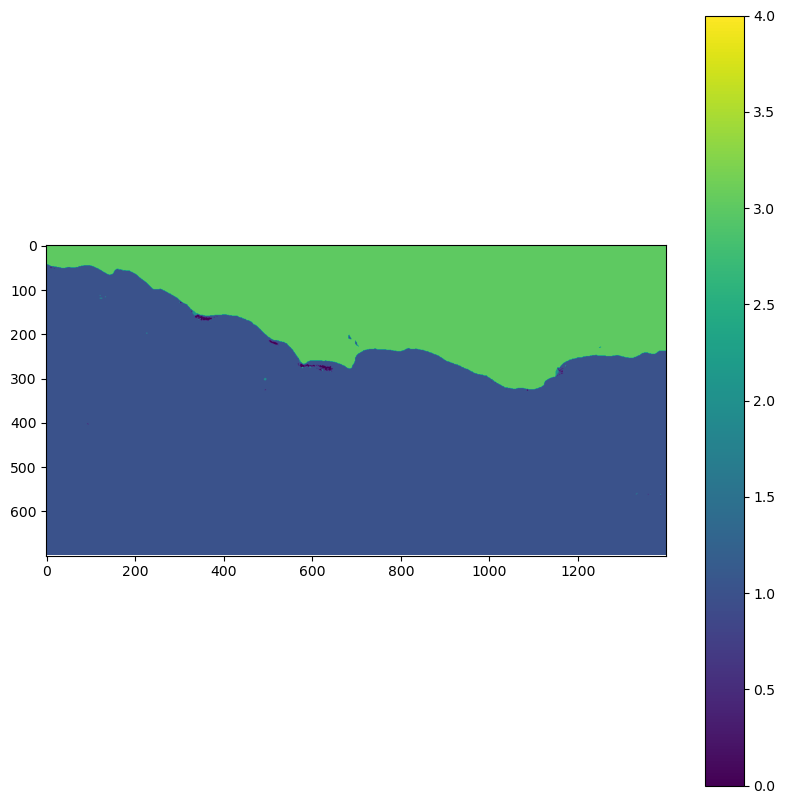

HLS.L30.T11SKU.2018026T183403.v2.0_kelp_classified.tif


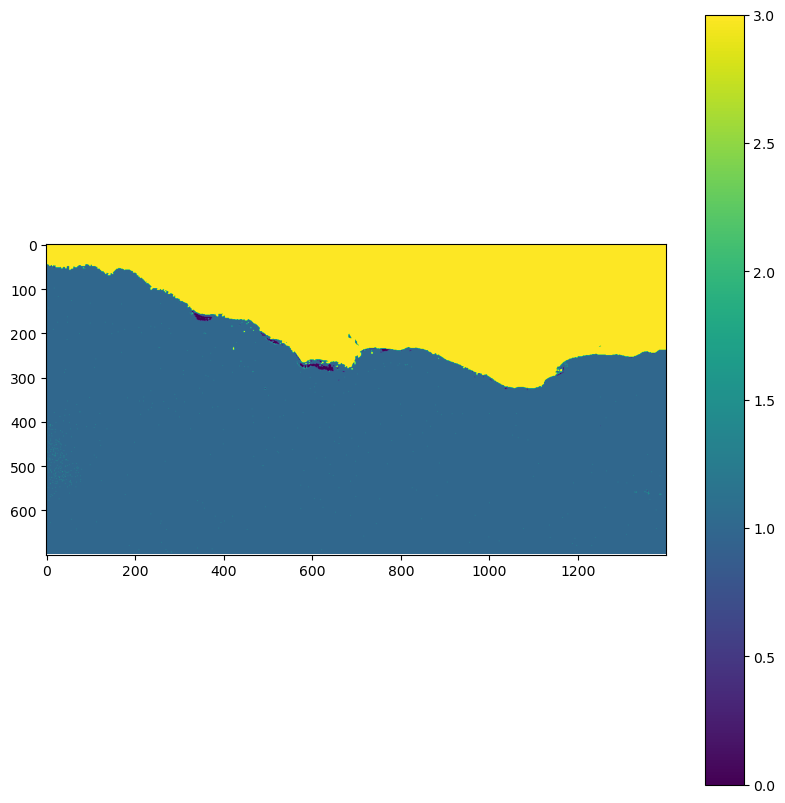

HLS.L30.T11SKU.2018058T183349.v2.0_kelp_classified.tif


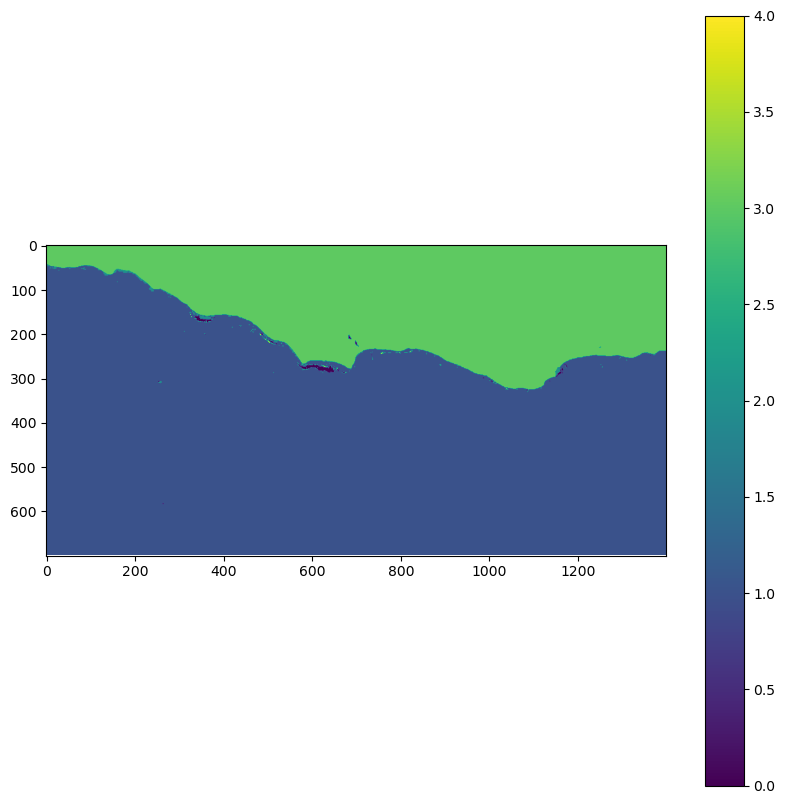

HLS.L30.T11SKU.2018362T183359.v2.0_kelp_classified.tif


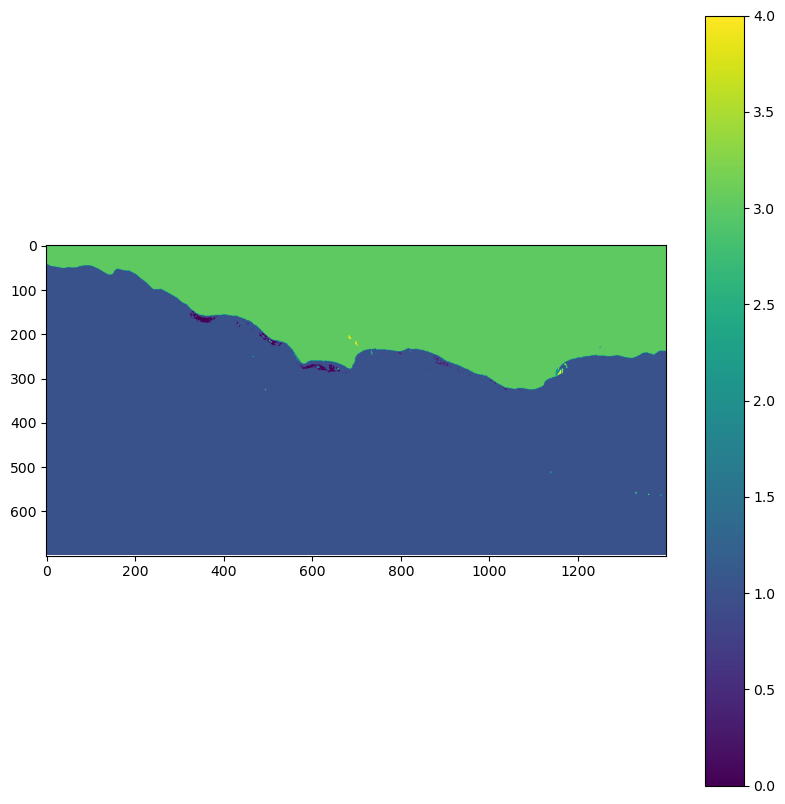

In [9]:
path = r'/mnt/c/Users/attic/HLS_Kelp/imagery/rf_training_V2'
files = os.listdir(path)
training_data = []
cmap = ListedColormap(['red', 'blue', 'green'])
for i, file in enumerate(files):
    with rasterio.open(os.path.join(path, file)) as src:
        training_img = src.read(7)  
        print(file)
        plt.figure(figsize=(10, 10))
        plt.imshow(training_img[2700:3400,600:2000])
        plt.colorbar()
        plt.show()  

# plt.figure(figsize=(6, 6))
# plt.imshow(training_img[6,:], cmap='gray')
# plt.show()  